In [1]:
import os
import sys
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from pathlib import Path
from functools import reduce
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.label import RULLabelAnnotator
from src.feature import BatLiNetFeatureExtractor as FeatureExtractor

plt.rcParams['font.family'] = 'arial' 
plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

In [2]:
with open(HOME / 'cache/transfer.pkl', 'rb') as f:
    mat2bat = pickle.load(f)

In [3]:
class ConvModule(nn.Module):
    def __init__(self, din, dout, kernel_size,
                 act_fn: str = 'relu',
                 dropout: float = 0.1):
        nn.Module.__init__(self)
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(din, dout, kernel_size)
        self.pool1 = nn.AvgPool2d(kernel_size)
        self.conv2 = nn.Conv2d(dout, dout, kernel_size)
        self.pool2 = nn.AvgPool2d(kernel_size)
        self.act_fn = getattr(torch, act_fn)
        self.dropout = nn.Dropout2d(dropout)

    def output_shape(self, H, W):
        # conv1 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool1 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)
        # conv2 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool2 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)

        return H, W

    def forward(self, x):
        x = self.conv1(x)
        x = self.act_fn(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act_fn(x)
        x = self.pool2(x)

        return x


class CNNRULPredictor(nn.Module):
    def __init__(self,
                 in_channels: int,
                 channels: int,
                 input_height: int,
                 input_width: int,
                 kernel_size=3,
                 act_fn: str = 'relu'):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)
        self.encoder = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.encoder.output_shape(input_height, input_width)
        self.proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1)

    def forward(self, feature: torch.Tensor):
        x = self.encoder(feature)
        x = self.proj(x)
        x = x.view(-1, self.channels)
        x = torch.relu(x)
        x = self.fc(x).view(-1)

        return x


class BatLiNetRULPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        channels: int,
        input_height: int,
        input_width: int,
        kernel_size: int = 3,
        alpha: float = 0.5,
        act_fn: str = 'relu'
    ):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)

        self.ori_enc = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.ori_enc.output_shape(input_height, input_width)
        self.ori_proj = nn.Conv2d(channels, channels, (H, W))
        self.sup_enc = ConvModule(in_channels, channels, kernel_size, act_fn)
        self.sup_proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1, bias=False)
        self.alpha = alpha
        self.w1 = nn.Parameter(torch.tensor(0.))
        self.w2 = nn.Parameter(torch.tensor(0.))

    def forward(
        self,
        feature: torch.Tensor,
        support_feature: torch.Tensor,
        support_label: torch.Tensor
    ):
        B, S, C, H, W = support_feature.size()

        x_ori = torch.relu(self.ori_proj(self.ori_enc(feature)))
        x_sup = torch.relu(self.sup_proj(self.sup_enc(support_feature.view(-1, C, H, W))))

        y_ori = self.fc(x_ori.view(B, self.channels)).view(-1) + self.w1
        y_sup = self.fc(x_sup.view(B, S, self.channels)).view(B, S) + self.w2

        return y_ori, y_sup

        if self.training:
            return y_ori * (1 - self.alpha) + self.alpha * y_sup.mean(-1)
        else:
            return y_ori, y_sup


class Dataset:
    def __init__(
        self,
        features,
        labels,
        sup_features=None,
        sup_labels=None,
        sup_size: int = 32,
        use_zscore: bool = True,
        label_mean=None,
        label_std=None,
    ):
        self.features = features.float()
        self.labels = labels.float()
        if sup_features is not None:
            sup_features = sup_features.float()
        if sup_labels is not None:
            sup_labels = sup_labels.float()
        self.sup_features = sup_features
        self.sup_labels = sup_labels
        self.sup_size = sup_size

        self.use_zscore = use_zscore
        self.label_mean = label_mean
        self.label_std = label_std

        if use_zscore:
            if self.label_mean is None:  # No label_mean and std provided
                self.label_mean = self.labels.mean().item()
                self.label_std = self.labels.std().item()
                if self.label_std != self.label_std:
                    self.label_std = 1.

    def is_intercd_dataset(self):
        return self.sup_features is not None and self.sup_labels is not None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        if self.is_intercd_dataset():
            feature, label = self.features[item], self.labels[item]
            # Choose the support set
            sup_index = torch.randint(len(self.sup_features), (self.sup_size,))
            sup_feat = feature.unsqueeze(0) - self.sup_features[sup_index]
            sup_label = self.sup_labels[sup_index]
            # zscore
            if self.use_zscore:
                label = (label - self.label_mean) / self.label_std
                sup_label = (sup_label - self.label_mean) / self.label_std
            feature = feature - feature[:, [10]]
            return feature, label, sup_feat, sup_label
        else:
            feature = self.features[item] - self.features[item][:, [10]]
            if self.use_zscore:
                label = (self.labels[item] - self.label_mean) / self.label_std
                return self.features[item], label
            return self.features[item], self.labels[item]

    def to(self, device):
        self.labels = self.labels.to(device)
        self.features = self.features.to(device)
        if self.is_intercd_dataset():
            self.sup_labels = self.sup_labels.to(device)
            self.sup_features = self.sup_features.to(device)
        return self

In [4]:
def train(model,
          dataset,
          device,
          num_epochs,
          val_data=None,
          eval_data=None,
          batch_size=32,
          show_progress=False,
          label_log=False,
          desc='Training',
          toleration=5,
          is_intra_diff=True,
          lr=1e-3):
    model.train()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)
    if eval_data is not None:
        eval_data_device = eval_data.features.device
        eval_data = eval_data.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Training
    min_val_loss = torch.inf
    cur_tolerance = 0
    terminate = False
    if show_progress:
        pbar = tqdm(range(num_epochs), desc=desc)
    else:
        pbar = range(num_epochs)
    for epoch in pbar:
        if terminate:
            break
        if is_intra_diff:
            for feat, label in dataloader:
                optimizer.zero_grad()
                feat = remove_glitches(feat)
                pred = model(feat)

                if label_log:
                    with torch.no_grad():
                        label = label.log()

                loss = torch.mean((label - pred) ** 2)

                loss.backward()
                optimizer.step()
        else:
            for feat, label, sup_feat, sup_label in dataloader:
                optimizer.zero_grad()
                feat, sup_feat = remove_glitches(feat), remove_glitches(sup_feat)
                if label_log:
                    with torch.no_grad():
                        label, sup_label = label.log(), sup_label.log()
                y_ori, y_sup = model(feat, sup_feat, sup_label)
                loss = torch.mean((label - y_ori) ** 2) \
                    + torch.mean((y_sup - (label[:, None] - sup_label)) ** 2)
                loss.backward()
                optimizer.step()
        if val_data is not None:
            loss = predict(
                model, val_data, device,
                batch_size=1,
                label_log=label_log,
                is_intra_diff=is_intra_diff,
                return_loss=True)
            if loss < min_val_loss:
                min_val_loss = loss
                best_state_dict = model.state_dict().copy()
                cur_tolerance = 0
            else:
                cur_tolerance += 1
                if cur_tolerance >= toleration:
                    terminate = True
                    break

    if val_data is not None:
        model.load_state_dict(best_state_dict)

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)
    if eval_data is not None:
        eval_data = eval_data.to(eval_data_device)
        pred = predict(
            model, eval_data, device,
            is_intra_diff=is_intra_diff,
            label_log=label_log,
            batch_size=1)
        return pred.to(model_device)

@torch.no_grad()
def predict(model, dataset, device,
            batch_size=32,
            label_log=False,
            is_intra_diff=True,
            return_loss=False):
    model.eval()
    model_device = next(model.parameters()).device
    dataset_device = dataset[0][0].device
    model, dataset = model.to(device), dataset.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    preds, loss = [], []
    if is_intra_diff:
        for feat, label in dataloader:
            feat = remove_glitches(feat)
            pred = model(feat)
            loss.append((label-pred) ** 2)
            preds.append(pred)
    else:
        for feat, label, sup_feat, sup_label in dataloader:
            feat, sup_feat = remove_glitches(feat), remove_glitches(sup_feat)
            pred, sup_pred = model(feat, sup_feat, sup_label)
            sup_pred += sup_label
            for i in range(len(pred)):
                pos_pred = [
                    x for x in sup_pred[i]
                    if x * dataset.label_std + dataset.label_mean > 0
                ]
                if pos_pred:
                    med = torch.median(
                        torch.tensor(pos_pred, device=pred.device)
                    )
                    pred[i] = pred[i] * 0.5 + 0.5 * med
            loss.append((label - pred) ** 2)
            preds.append(pred)
    preds = torch.cat(preds)
    loss = torch.cat(loss).mean()
    if dataset.use_zscore:
        preds = preds * dataset.label_std + dataset.label_mean
    if label_log:
        preds = preds.exp()

    # Map device back
    model = model.to(model_device)
    dataset = dataset.to(dataset_device)

    if return_loss:
        return loss
    return preds.to(model_device)


@torch.no_grad()
def remove_glitches(data, ths: float = 2.0):
    data[data.abs() > ths] = 0.
    return data

In [5]:
def get_intracd_dataset(bats, cycle_diff_base=9):
    features = torch.stack([bat.feature for bat in bats])
    labels = torch.stack([bat.label for bat in bats])

    features = features - features[:, :, [cycle_diff_base]]

    return Dataset(features, labels)

def get_intercd_datasets(bats, sup_bats, **kwargs):
    features = torch.stack([bat.feature for bat in bats])
    sup_features = torch.stack([bat.feature for bat in sup_bats])
    labels = torch.stack([bat.label for bat in bats])
    sup_labels = torch.stack([bat.label for bat in sup_bats])

    return Dataset(features, labels, sup_features, sup_labels, **kwargs)

def rmse(x, y):
    return torch.mean((x - y) ** 2) ** 0.5

def mape(x, y):
    return torch.mean((x - y).abs() / y)

def mstd(x, y):
    return torch.std((x - y).abs())

## Experiments

In [6]:
def run_parallel(num_gpus, study_type, train_count, workspace, mat2bat):
    with ThreadPoolExecutor(max_workers=num_gpus) as executor:
        futures = []
  
        # Submit tasks to run in parallel
        for seed in range(num_gpus):
            future = executor.submit(
                exp, study_type, seed, train_count, workspace, mat2bat)
  
            futures.append(future)
  
        # Wait for all tasks to complete
        for future in futures:
            future.result()

def exp(
    study_type,
    seed,
    n_train_cells,
    workspace,
    mat2bat,
    show_progress=False
):
    show_progress = False

    os.makedirs(workspace, exist_ok=True)
    result_file = Path(workspace) / f'preds.{seed}.pkl'
    # if result_file.exists():
    #     return
    device = f'cuda:{seed}'

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    support_cells = reduce(
        lambda x, y: x + y,
        [bat for mat, bat in mat2bat.items() if mat == 'LFP']
    )
    train_cells = random.sample(mat2bat[study_type], n_train_cells)
    test_cells = [bat for bat in mat2bat[study_type] if bat not in train_cells]

    channels = 32
    in_channels = 6
    num_early_cycles = 100
    interp_dims = 1000

    train_data_intracd = get_intracd_dataset(train_cells)
    data_finetune = get_intracd_dataset(support_cells)
    test_data_intracd = get_intracd_dataset(test_cells)
    test_data_intracd.label_mean = train_data_intracd.label_mean
    test_data_intracd.label_std = train_data_intracd.label_std

    train_data_batlinet = get_intercd_datasets(train_cells, support_cells, sup_size=2)
    test_data_batlinet = get_intercd_datasets(test_cells, support_cells, sup_size=32)
    test_data_batlinet.label_mean = train_data_batlinet.label_mean
    test_data_batlinet.label_std = train_data_batlinet.label_std

    model_finetune = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    model_intracd = CNNRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)
    batlinet = BatLiNetRULPredictor(
        in_channels, channels, num_early_cycles, interp_dims)

    batlinet_preds = train(
        batlinet,
        train_data_batlinet,
        eval_data=test_data_batlinet,
        device=device,
        show_progress=show_progress,
        desc='Training BatLiNet',
        num_epochs=1000,
        is_intra_diff=False,
        batch_size=32)
    train(
        model_finetune,
        data_finetune,
        device=device,
        num_epochs=100,
        batch_size=32,
        show_progress=show_progress,
        desc='Finetuning'
    )
    finetune_preds = train(
        model_finetune,
        train_data_intracd,
        eval_data=test_data_intracd,
        device=device,
        show_progress=show_progress,
        desc='Transfer after finetuning',
        batch_size=32,
        num_epochs=100)
    intracd_preds = train(
        model_intracd,
        train_data_intracd,
        eval_data=test_data_intracd,
        toleration=10,
        show_progress=show_progress,
        desc='Training IntraCD',
        device=device,
        batch_size=32,
        num_epochs=100)
    label = test_data_intracd.labels

    ans = {
        'batlinet_preds': batlinet_preds,
        'intracd_preds': intracd_preds,
        'finetune_preds': finetune_preds,
        'labels': label
    }

    print(ans)

    print(mape(batlinet_preds, label))
    print(mape(intracd_preds, label))
    print(mape(finetune_preds, label))

    with open(result_file, 'wb') as f:
        pickle.dump(ans, f)

In [7]:
num_gpus = 1
workspace = HOME / 'workspaces/transfer'
train_counts = {
    'LCO': [16],
    'NMC': [16],
    'NCA': [8],
    # 'NCA': [1, 2, 4, 8],
    # 'NMC': [1, 2, 4, 8, 16],
    # 'LCO': [1, 2, 4, 8, 16]
}
for study_type, n_train_counts in train_counts.items():
    for n_train_count in n_train_counts:
        print(f'Processing {study_type}, {n_train_count}')
        run_parallel(
            num_gpus, study_type, n_train_count,
            f'{workspace}/{study_type}_{n_train_count}', mat2bat
        )

Processing LCO, 16
{'batlinet_preds': tensor([999.6985, 686.7292, 763.7426, 553.3442, 456.4085, 929.2810, 770.4493,
        505.8681, 347.4420, 356.1401, 334.8603, 355.7272, 334.9442, 349.9564,
        357.8312, 357.6479, 190.9816, 253.0619, 242.4752, 288.0713, 455.5886]), 'intracd_preds': tensor([556.3804, 585.1631, 586.6628, 532.3435, 465.0612, 829.4249, 589.0416,
        589.7213, 273.1796, 241.7274, 261.0193, 342.6655, 241.8914, 252.4808,
        257.1394, 227.1956, 190.7368, 217.8253, 224.6120, 190.7957, 516.8998]), 'finetune_preds': tensor([321.2477, 321.2477, 321.2477, 321.2477, 321.2477, 843.2100, 419.3471,
        651.5766, 254.1593, 249.6336, 260.4451, 281.0078, 253.9319, 265.6475,
        254.2901, 247.0726, 174.9530, 196.8963, 187.1977, 321.2477, 317.3083]), 'labels': tensor([474., 449., 488., 539., 569., 535., 740., 520., 256., 247., 264., 235.,
        248., 219., 260., 232., 157., 296., 160., 196., 166.])}
tensor(0.4653)
tensor(0.2644)
tensor(0.2748)
Processing NMC, 16
{

In [ ]:
workspace =  Path('/workspace/battery/nmi_configs/workspaces/transfer')
preds = defaultdict(dict)
for path in workspace.glob('*'):
    mat, train_frac = path.name.split('_')
    preds_ = []
    for pred_file in path.glob('preds*.pkl'):
        with open(pred_file, 'rb') as f:
            pred = pickle.load(f)
        preds_.append(pred)
    preds[mat][train_frac] = preds_


In [ ]:
res = defaultdict(dict)
for material in ['NMC', 'LCO', 'NCA']:
    means, stds = [], []
    for train_frac in ['0.05', '0.1', '0.15', '0.2']:
        scores = [[], [], [], [], []]
        for seed in range(8):
            seed_preds = preds[material][train_frac][seed]
            scores[0].append(rmse(
                seed_preds['intercd_preds'], seed_preds['labels']
            ))
            scores[1].append(rmse(
                seed_preds['intracd_preds'], seed_preds['labels']
            ))
            scores[2].append(rmse(
                seed_preds['finetune_preds'], seed_preds['labels']
            ))
            scores[3].append(rmse(
                (seed_preds['intracd_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']))
            scores[4].append(rmse(
                (seed_preds['finetune_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']
            ))
        means.append([np.mean(x) for x in scores])
        stds.append([np.std(x) for x in scores])
    res[material]['means'] = means
    res[material]['stds'] = stds

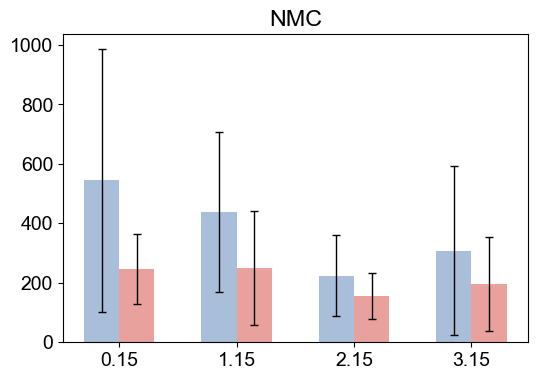

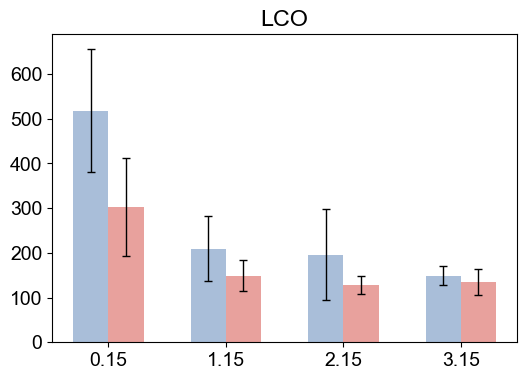

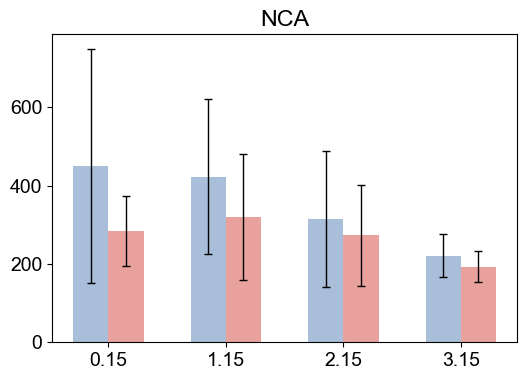

In [ ]:
# colors = ['#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']
colors = ['#A9BED9', '#E8A19D']
for material in ['NMC', 'LCO', 'NCA']:
    means, stds, mins, maxs = [], [], [], []
    for train_frac in ['0.05', '0.1', '0.15', '0.2']:
        scores = [[], [], [], [], []]
        for seed in range(8):
            seed_preds = preds[material][train_frac][seed]
            scores[0].append(rmse(
                seed_preds['intercd_preds'], seed_preds['labels']
            ))
            scores[1].append(rmse(
                seed_preds['intracd_preds'], seed_preds['labels']
            ))
            scores[2].append(rmse(
                seed_preds['finetune_preds'], seed_preds['labels']
            ))
            scores[3].append(rmse(
                (seed_preds['intracd_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']))
            scores[4].append(rmse(
                (seed_preds['finetune_preds'] + seed_preds['intercd_preds']) / 2,
                seed_preds['labels']
            ))
        means.append([np.mean(x) for x in scores])
        stds.append([np.std(x) for x in scores])
        mins.append([np.min(x) for x in scores])
        maxs.append([np.max(x) for x in scores])
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    x = np.arange(4)
    ax.bar(
        x,
        [i[2] for i in means],
        width=0.3,
        color=colors[0],
        yerr=[i[2] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    ax.bar(
        x+0.3,
        [i[3] for i in means],
        width=0.3,
        color=colors[1],
        yerr=[i[3] for i in stds],
        error_kw=dict(capsize=3, capthick=1, lw=1),
        # error bar color is darker than grey
        ecolor='black')
    # plt.plot(x, [i[2] for i in means], color=colors[2])
    # plt.fill_between(
    #     x,
    #     [i[2] for i in mins],
    #     [i[2] for i in maxs],
    #     color=colors[2],
    #     alpha=0.2)
    # plt.plot(x, [i[3] for i in means], color=colors[0])
    # plt.fill_between(
    #     x,
    #     [i[3] for i in mins],
    #     [i[3] for i in maxs],
    #     color=colors[0],
    #     alpha=0.2)
    ax.set_xticks(x+0.15)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # fig.savefig(
    #     f'visualization/temp/transfer_bar_{material}.svg',
    #     bbox_inches='tight',
    #     pad_inches=0.1)
    ax.set_title(material)
    plt.show()